In [ ]:
# Step 1. Mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import cv2

from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
!pip install split-folders
import splitfolders

In [ ]:
original = "/content/gdrive/MyDrive/Data"
output = "/content/gdrive/MyDrive/Data_OCC"

In [ ]:
splitfolders.ratio(original, output, seed = 33, ratio=(.8, .0, .2), group_prefix=None) # default values

Copying files: 145 files [00:37,  3.88 files/s]


In [ ]:
### DEFINE SOME PARAMETERS ###

base_path = "/content/gdrive/MyDrive/Data_OCC"
SHAPE = (224,224,3)
batch_size = 16

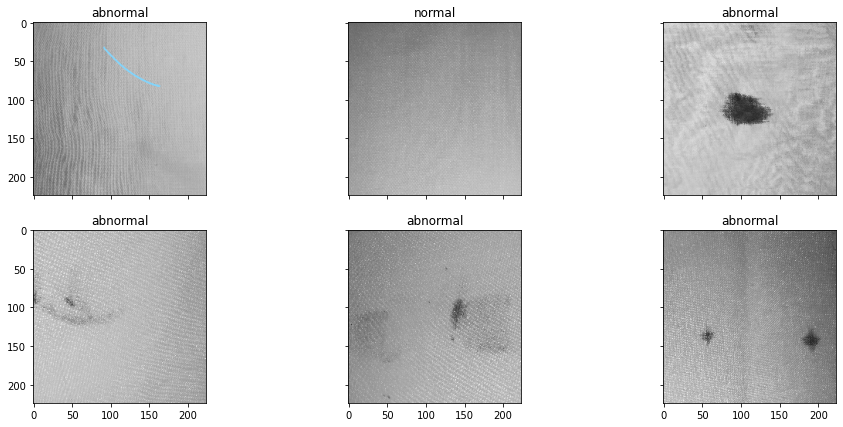

In [ ]:
### PLOT SAMPLE IMAGES ###

f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))

for ax in axes.ravel():
    label = np.random.choice(os.listdir(base_path + "/train"))
    img = np.random.choice(os.listdir(base_path + "/train/" + label))
    img = cv2.imread(base_path + "/train/" + label + "/" + img)
    img = cv2.resize(img, SHAPE[:2])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    ax.set_title(label)

In [ ]:
### GENERATOR WRAPPER TO CREATE FAKE LABEL ###

def wrap_generator(generator):
    
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        
        yield x,y

In [ ]:
base_model = ResNet50(weights='imagenet',include_top=True, input_shape=SHAPE)
base_model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(train=True):
    
    set_seed(33)
    
    pre_process = Lambda(preprocess_input)
    resnet = ResNet50(weights = 'imagenet', include_top = True, input_shape = SHAPE)
    
    resnet = Model(resnet.input, resnet.layers[-2].output)

    resnet.trainable = False
    
    inp = Input(SHAPE)
    resnet_50_process = pre_process(GaussianNoise(0.1)(inp))
    resnet_out = resnet(resnet_50_process)
    
    noise = Lambda(tf.zeros_like)(resnet_out)
    noise = GaussianNoise(0.1)(noise)

    if train:
        x = Lambda(lambda z: tf.concat(z, axis=0))([resnet_out,noise])
        x = Activation('relu')(x)
    else:
        x = resnet_out
        
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(Adam(lr=1e-4), loss='binary_crossentropy')

    return model



In [ ]:
model = get_model()

# Display the model's architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 224, 224, 3)  0          ['input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['gaussian_noise[0][0]']         
                                                                                                  
 model (Functional)             (None, 2048)         23587712    ['lambda[0][0]']           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            base_path + '/train',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['normal']
    )

test_generator = test_datagen.flow_from_directory(
            base_path + '/test',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['abnormal','normal']
)


Found 32 images belonging to 1 classes.
Found 29 images belonging to 2 classes.


In [ ]:
 steps_per_epoch=train_generator.samples/train_generator.batch_size
 print(steps_per_epoch)

2.0


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)

model = get_model()
model.fit(wrap_generator(train_generator), steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=70)
model.save('/content/gdrive/MyDrive/weight/fabric_new_1.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
2/2 [==============================] - 10s 953ms/step - loss: 0.9158
Epoch 2/70
2/2 [==============================] - 1s 569ms/step - loss: 0.6408
Epoch 3/70
2/2 [==============================] - 1s 600ms/step - loss: 0.5121
Epoch 4/70
2/2 [==============================] - 1s 580ms/step - loss: 0.4518
Epoch 5/70
2/2 [==============================] - 1s 564ms/step - loss: 0.3788
Epoch 6/70
2/2 [==============================] - 1s 570ms/step - loss: 0.3530
Epoch 7/70
2/2 [==============================] - 1s 547ms/step - loss: 0.3351
Epoch 8/70
2/2 [==============================] - 1s 571ms/step - loss: 0.3141
Epoch 9/70
2/2 [==============================] - 1s 575ms/step - loss: 0.3142
Epoch 10/70
2/2 [==============================] - 1s 566ms/step - loss: 0.2854
Epoch 11/70
2/2 [==============================] - 1s 584ms/step - loss: 0.2795
Epoch 12/70
2/2 [==============================] - 1s 623ms/step - loss: 0.2516
Epoch 13/70
2/2 [==============================]

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape

(29,)

In [ ]:
### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = get_model(train=False)
ineference_model.load_weights('/content/gdrive/MyDrive/weight/fabric_new_1.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
### COMPUTE PREDICTIONS ON TEST DATA ##

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)

In [ ]:
print(pred_test.shape)

(29,)


In [ ]:
### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))

ACCURACY: 0.9310344827586207


In [ ]:
cfn_matrix = confusion_matrix(label_test, pred_test)

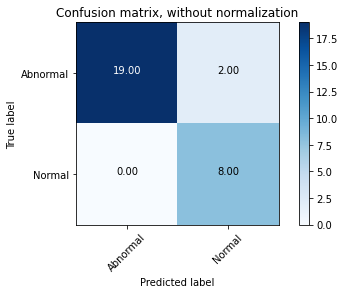

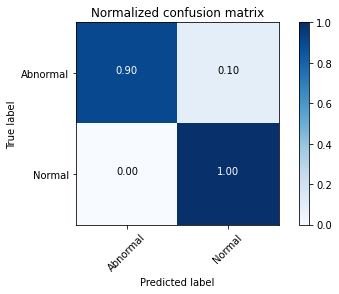

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = ['Abnormal', 'Normal']
plt.figure()
plot_confusion_matrix(cfn_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfn_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
class_names = ['abnormal','normal']

In [ ]:
img_path = '/content/gdrive/MyDrive/Data_OCC/test/abnormal/18.jpg'

In [ ]:
img = tf.keras.utils.load_img(
    img_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = ineference_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)

This image most likely belongs to abnormal.
